# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa
import librosa.display
from scipy.signal import find_peaks

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# change to this notebook's directory
!ls '/content/drive/My Drive/UVic/Synthesizer Programming'
path = '/content/drive/My Drive/UVic/Synthesizer Programming/'

Mounted at /content/drive
2001_alto.csv	 2001_tenor.csv		  Assignment1.ipynb  CeramicMug.wav
2001_bass.csv	 2001_treble.csv	  Assignment2.ipynb  fm_synthesis.ipynb
2001_melody.csv  additive_synthcsp.ipynb  Assignment3.ipynb  GlassMug.wav


# Q3

## Load Audio

In [3]:
sr = 44100

In [4]:
glass, _ = librosa.load(path + 'GlassMug.wav', sr=sr)
ceramic, _ = librosa.load(path + 'CeramicMug.wav', sr=sr)

In [5]:
ipd.display(ipd.Audio(glass, rate=sr))
ipd.display(ipd.Audio(ceramic, rate=sr))

## Plot spectra

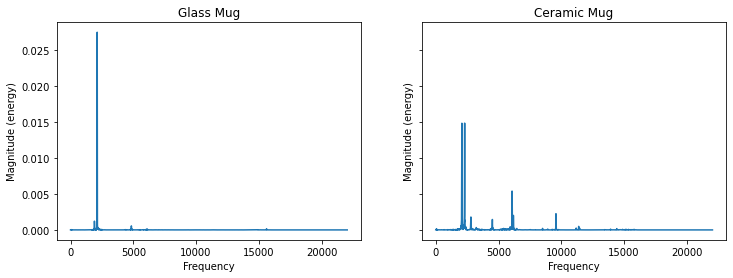

In [6]:
fig, axs = plt.subplots(1,2, figsize=(12,4), sharey=True)

axs[0].magnitude_spectrum(glass, Fs=sr)
axs[1].magnitude_spectrum(ceramic, Fs=sr)

axs[0].set_title('Glass Mug')
axs[1].set_title('Ceramic Mug')

plt.show()

# Q4

## Base Code

In [7]:
def sinusoid(freq=440.0, dur=1.0, srate=44100.0, amp=1.0, phase = 0.0): 
    t = np.linspace(0,dur,int(srate*dur))
    data = amp * np.sin(2*np.pi*freq *t+phase)
    return data

In [8]:
def envelope(segments,srate,duration): 
    nsamples = int(srate*duration)
    value = 0.0
    segment_index = 0 
    data = np.zeros(nsamples)
    segment_sample = 0 
    prev_target = 0.0

    for i in np.arange(nsamples): 
        if (segment_index < len(segments)): 
            target = segments[segment_index][0]
            ramp_time = segments[segment_index][1]
            delay_time = segments[segment_index][2]
            
            ramp_samples = (ramp_time / 1000.0) * srate 
            delay_samples = (delay_time / 1000.0) * srate
            
            if i < segment_sample + ramp_samples: 
                incr = (target-prev_target) / ramp_samples 
            elif i < segment_sample + ramp_samples + delay_samples: 
                incr = 0.0 
            else: 
                if ramp_samples != 0.0: 
                    incr = (target-prev_target) / ramp_samples 
                else: 
                    incr = 0.0 
                segment_sample = i 
                segment_index = segment_index+1 
                prev_target = target 
            value = value + incr 
        data[i] = value
    return data  

## Get Frequency Peaks

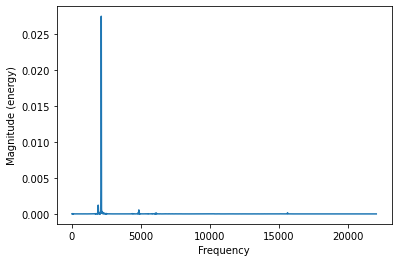

In [54]:
spec, freqs, _ = plt.magnitude_spectrum(glass, Fs=sr)
peaks_idc, _ = find_peaks(spec, height=0.0003, distance=10)
peak_vals_glass = freqs[peaks_idc]

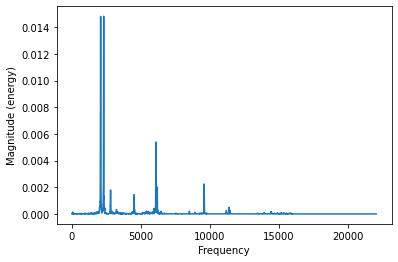

In [55]:

spec, freqs, _ = plt.magnitude_spectrum(ceramic, Fs=sr)
peaks_idc, _ = find_peaks(spec, height=0.002, distance=18)
peak_vals_ceramic = freqs[peaks_idc]


## Additive Synthesis

In [67]:
dur = 4.0

s1 = [(0.8, 50, 0), (1,200,50), (0.5, 900, 250), (0,1000, 1150)]
s2 = [(0.8, 100, 0), (0.35, 200, 100), (0.2, 1200, 1200), (0,2000, 2400)]
s3 = [(0.9, 120, 0), (0.45, 500, 120), (0, 1000, 4000)]
s4 = [(0.95,400,100), (0.2, 400, 500), (0.3, 900, 900), (0, 1000, 1900)]

penv1 = envelope(s1, sr, dur)
penv2 = envelope(s2, sr, dur)
penv3 = envelope(s3, sr, dur)
penv4 = envelope(s4, sr, dur)

# Glass Mug
osc1 = sinusoid(peak_vals_glass[0], amp=0.25, dur=dur)
osc2 = sinusoid(peak_vals_glass[1], amp=0.25, dur=dur)
osc3 = sinusoid(peak_vals_glass[2], amp=0.25, dur=dur)
osc4 = sinusoid(peak_vals_glass[3], amp=0.25, dur=dur)
glass_add_out = 0.25 * (penv1 * osc1 + penv2 * osc2 + penv3 * osc3 + penv4 * osc4)

ipd.display(ipd.Audio(glass_add_out, rate=sr))

# Ceramic Mug
osc1 = sinusoid(peak_vals_ceramic[0], amp=0.25, dur=dur)
osc2 = sinusoid(peak_vals_ceramic[1], amp=0.25, dur=dur)
osc3 = sinusoid(peak_vals_ceramic[2], amp=0.25, dur=dur)
osc4 = sinusoid(peak_vals_ceramic[3], amp=0.25, dur=dur)
ceramic_add_out = 0.25 * (penv1 * osc1 + penv2 * osc2 + penv3 * osc3 + penv4 * osc4)

ipd.display(ipd.Audio(ceramic_add_out, rate=sr))

Upon first listen, it's difficult to determine which model was derived from the glass or ceramic mug. They both have dissonant intervals occurring from frequencies very close to each other as shown in the magnitude spectra around 2 kHz, and more harmonious pitches (most likely multiples of the fundamental) in the 5-10 kHz range. The only way I can tell which is the glass mug is by knowing the glass mug recording sounded like a lower pitch than the ceramic mug.

# Q5

## Base Code

In [57]:
def mass_spring_damper_approximate(m = 0.001, k=1000, r = 0.002): 
    oversampling = 50
    T = 1.0 / (sr * oversampling)
    temp = (m + (T*r) + (T*T*k))
    coeff1 = ((2.0 * m) + (T*r)) / temp
    coeff2 = -m / temp 
    Y = np.zeros(2)
    approximate = np.zeros(int(sr * 4.0))
    Y = np.zeros(3)
    Y[1]=1.0 
    Y[2]=0.0 
    
    for i in range(0, int(sr * 4.0)):
        for j in range(0, oversampling): 
            Y[0] = (Y[1] * coeff1) + (Y[2]*coeff2)
            Y[2] = Y[1] 
            Y[1] = Y[0]
        approximate[i]= Y[1]-Y[2]
    return approximate

In [59]:
import scipy.signal

In [60]:
def modal_resonance(audio, amp, freq, radius, sr): 
    b = np.ones(1)
    a = np.zeros(3)
    a[0] = 1.0 
    a[1] = -2*radius * np.cos(2*np.pi*freq*(1.0/sr))
    a[2] = radius * radius 
    # apply filter
    filtered_audio = amp * scipy.signal.lfilter(b, a, audio)
    return filtered_audio 

def modal_note(fundamental, excitation, N): 
    # Mode parameters
    nModes = 4
    freqs = fundamental * np.array([1.0, 1.81,2.27, 4.54]) # modal center frequencies
    radii = [ 0.999, 0.9999, 0.9995, 0.9995] # modal radii
    amps = [40, 60, 50, 70]    
    
    modes = [] 
    mix = np.zeros(N)
    for m in np.arange(0, nModes): 
        modes.append(modal_resonance(excitation, amps[m], freqs[m], radii[m], sr))
        mix += modes[m]
        # normalize modes after mixing for individual playback 
        modes[m] = 0.5 * (modes[m] / np.max(modes[m]))
    mix = 0.5 * (mix / np.max(mix))
    return mix, modes 

## Modal Synthesis

In [61]:
N = int(1.5 * sr)
impulse = np.zeros(N)
impulse[0] = 1

In [65]:
# Glass Mug
(mix1, modes) = modal_note(peak_vals_glass[0], impulse, N)
(mix2, modes) = modal_note(peak_vals_glass[1], impulse, N)
(mix3, modes) = modal_note(peak_vals_glass[2], impulse, N)
(mix4, modes) = modal_note(peak_vals_glass[3], impulse, N)

glass_modal_out = (mix1 + mix2 + mix3 + mix4) * 0.25

ipd.Audio(glass_modal_out, rate=sr)

In [66]:
# Ceramic Mug
(mix1, modes) = modal_note(peak_vals_ceramic[0], impulse, N)
(mix2, modes) = modal_note(peak_vals_ceramic[1], impulse, N)
(mix3, modes) = modal_note(peak_vals_ceramic[2], impulse, N)
(mix4, modes) = modal_note(peak_vals_ceramic[3], impulse, N)

ceramic_modal_out = (mix1 + mix2 + mix3 + mix4) * 0.25

ipd.Audio(ceramic_modal_out, rate=sr)

The glass mug model sounds reminiscent of finger cymbals, with more of a ringing effect, whereas the ceramic mug initially sounds like a cowbell that transitions to more of a triangle. I feel like the cowbell-like impact is a dead giveaway for it being the ceramic mug; and the harmony of the "finger cymbals" feels more similar to glass (e.g., wine glasses).

# Q6

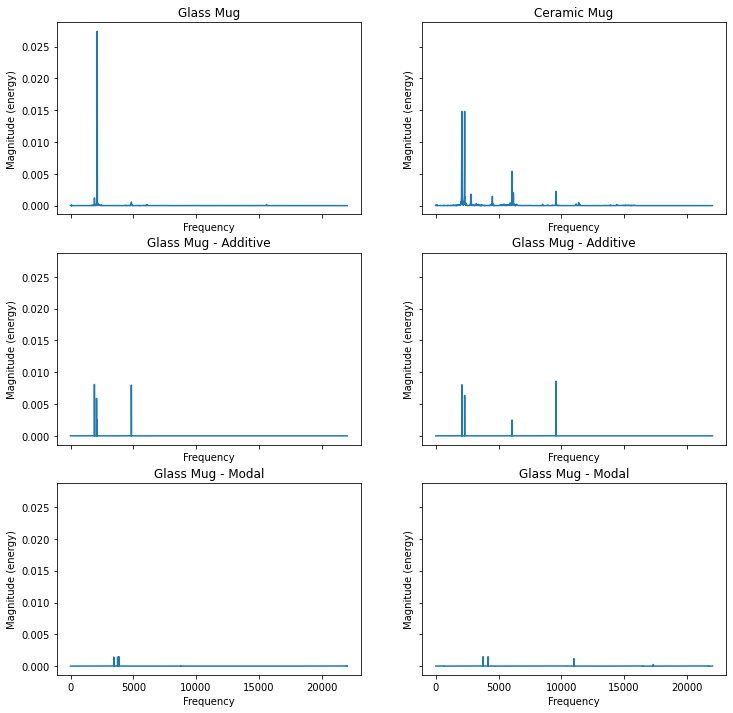

In [69]:
fig, axs = plt.subplots(3,2, figsize=(12,12), sharex=True, sharey=True)

axs[0,0].magnitude_spectrum(glass, Fs=sr)
axs[0,1].magnitude_spectrum(ceramic, Fs=sr)
axs[1,0].magnitude_spectrum(glass_add_out, Fs=sr)
axs[1,1].magnitude_spectrum(ceramic_add_out, Fs=sr)
axs[2,0].magnitude_spectrum(glass_modal_out, Fs=sr)
axs[2,1].magnitude_spectrum(ceramic_modal_out, Fs=sr)

axs[0,0].set_title('Glass Mug')
axs[0,1].set_title('Ceramic Mug')
axs[1,0].set_title('Glass Mug - Additive')
axs[1,1].set_title('Glass Mug - Additive')
axs[2,0].set_title('Glass Mug - Modal')
axs[2,1].set_title('Glass Mug - Modal')

plt.show()